# Breast Cancer Analysis with Logistic Regression and RBF Network

In [42]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import rbf
import importlib
from math import sqrt

In [43]:
# Load the breast cancer dataset
data = load_breast_cancer()

# Convert to pandas DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = (data.target == 0).astype(int)  # Binary target: 0 (malignant) -> 1, 1 (benign) -> 0

# Split the dataset into 70% training and 30% testing
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optionally, convert back to DataFrame after scaling
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

X_train.shape

(398, 30)

## Logistic regression on the original dataset

In [44]:
# Perform logistic regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# Compute the accuracy of the model
y_pred = logistic_regression.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

/Users/guilhermejose/Desktop/Machine-Learning/ml-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9707602339181286

In [45]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix


array([[107,   1],
       [  4,  59]])

In [46]:
# Compute the specificity and recall
specificity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print(f"Specificity: {specificity}")

recall = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print(f"Recall: {recall}")

Specificity: 0.9365079365079365
Recall: 0.9907407407407407


In [47]:
# Perform Gaussian Mixture Model clustering, compute the silhouette score and store it
em_models = []
accuracies = []
for k in range(2, 11):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_train)
    y_pred = gmm.predict(X_test)
    score = silhouette_score(X_test, y_pred)
    accuracies.append(score)
    em_models.append(gmm)


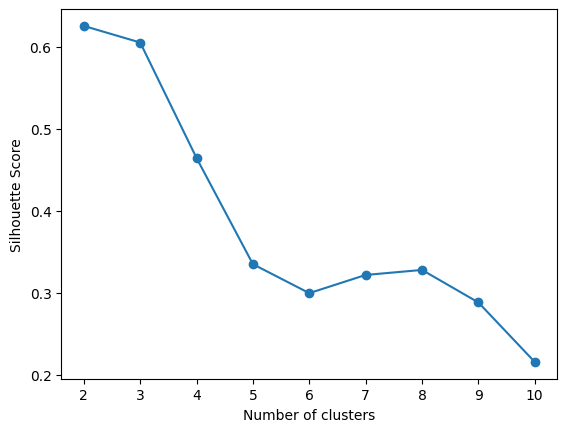

In [48]:
# Plot the silhouette results

plt.plot(range(2, 11), accuracies, marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

In [49]:
print(accuracies)

[np.float64(0.6257468244321635), np.float64(0.6055064812654978), np.float64(0.46464640801935553), np.float64(0.33517787941511795), np.float64(0.2998399482811989), np.float64(0.32202567651300235), np.float64(0.3281489889196877), np.float64(0.28851609056494903), np.float64(0.2159591171578482)]


The number of clusters with the highest silhouette aligns perfectly with the problem. With a binary target variable we got k = 2 as the optimal number of clusters.

## Transforming the Data for Different k Values

In this step, we trasform the data into probability values for each cluster. We will make several transformations for different values of __k__. Then we store the transformed dataset to later use.

In [9]:
# For different k values, transform and store the data
X_train_transformed = []
X_test_transformed = []
for em_model in em_models:
    X_train_transformed.append(em_model.predict_proba(X_train))
    X_test_transformed.append(em_model.predict_proba(X_test))

Here we apply logistic regression for each of the transformed dataset and then store it.

## Classifying patients based on the cluster probabilities
Here, we use the cluster probabilities to classify the patients.

In [51]:
# Perform logistic regression on the transformed data
accuracies = []
confusion_martrices = []

# For different k values, apply logistic regression, compute and store the accuracy and confusion matrix
for i in range(len(em_models)):
    model = LogisticRegression()
    model.fit(X_train_transformed[i], y_train)
    y_pred = model.predict(X_test_transformed[i])
    score = accuracy_score(y_test, y_pred)
    accuracies.append(score)
    confusion_martrices.append(confusion_matrix(y_test, y_pred))

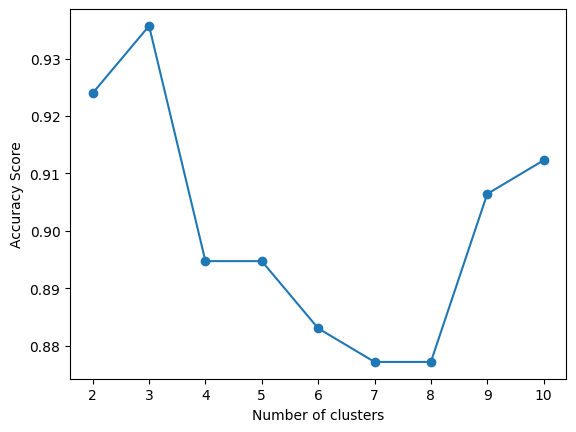

In [52]:
# Plot the accuracy scores against the number of clusters
plt.plot(range(2, 11), accuracies, marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Accuracy Score')
plt.show()

## Evaluating the model based on recall

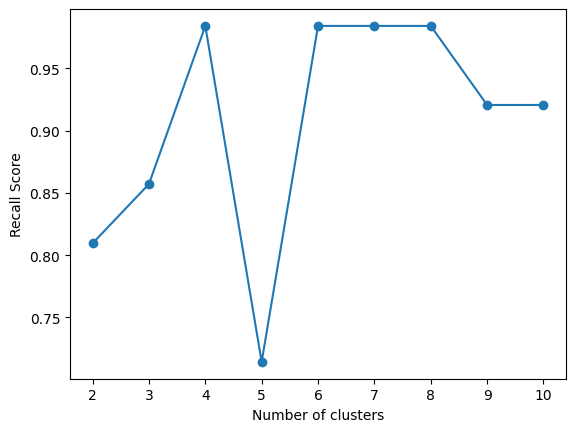

In [57]:
# Compute the recall across different k values
recalls = []
for matrix in confusion_martrices:
    recall = matrix[1, 1] / (matrix[1, 1] + matrix[1, 0])
    recalls.append(recall)

# Plot the recall scores against the number of clusters
plt.plot(range(2, 11), recalls, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Recall Score')
plt.show()

## RBF network with mapped dataset when k = 2

In [27]:
# Get the centers of cluster 1 and 2
centers = em_models[0].means_

# Sigma is the euclidean distance between the centers of the two clusters multiplied by square root of 2
sigma = sqrt(2) * np.linalg.norm(centers[0] - centers[1])

# Reload the module to get the latest changes
importlib.reload(rbf)

# Initialize and fit the model
model = rbf.RBFNetwork(centers=centers, sigma=sigma)
model.fit(X_train, y_train)

In [28]:
# Predict the test data and compute the accuracy
importlib.reload(rbf)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9298245614035088

In [29]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[108,   0],
       [ 12,  51]])